In [202]:
import pandas as pd
import os
import classify
from start import data_path
import numpy as np
import extract_laws
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.linear_model import Lasso
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [39]:
resample = False
resample = False
resample = False
resample = False
if resample:
    text_scraped = pd.read_csv(os.path.join(data_path, 'text_scraped.csv'))
    docs_to_label = text_scraped[['title', 'text', 'link']].sample(n = 700)
    docs_to_label['label'] = ''
    docs_to_label = docs_to_label[['title', 'label', 'text', 'link']]
    docs_to_label.to_csv(os.path.join(data_path, 'docs_to_label_curves.csv'))
    print('resampled')
    docs_to_label

In [203]:
labeled_docs = pd.read_csv(os.path.join(data_path, 'docs_to_label_curves_labelled.csv'))
print(labeled_docs['label'].value_counts())
labeled_docs.head(5)
labeled_docs = labeled_docs[(labeled_docs.label == True) | (labeled_docs.label == False)]
labeled_docs.head()


False    478
True     121
Name: label, dtype: int64


,Unnamed: 0,title,label,text,link
0,3816,Big Sandy ISD,False,Big Sandy ISD - Local District of Innovation P...,http://www.bigsandyisd.net/331880_3
1,372,Conroe ISD,True,Layout 1 Conroe ISD District of Innovation Pla...,https://conroeisd.net/wp-content/uploads/2016/...
2,1412,Montgomery ISD,False,UNAVAILABLE,/upload/template/0001/docs/Website%20Accessibi...
3,3971,Brazosport ISD,False,District of Innovation - Brazosport Independen...,http://www.brazosportisd.net/cms/one.aspx?port...
4,602,Shelbyville ISD,False,Pre-kindergarten S. W. CARTER ELEMENTARY SCHOO...,https://s3.amazonaws.com/scschoolfiles/464/sup...


In [204]:
docs_true = pd.read_csv(os.path.join(data_path, 'text_scraped.csv'))
docs_true = docs_true[docs_true.level == 'First']
docs_true = docs_true[docs_true.text != 'UNAVAILABLE']
docs_true = docs_true[docs_true.text != 'No text']
docs_true = docs_true[~docs_true.text.str.contains('Page Not Found')]
docs_true['label'] = True
docs_true = docs_true[['text', 'label']]

In [71]:
n_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]

# Dictionary

In [127]:
precisions = []
recalls = []
fmeasures = []
dict_docs = sample_docs[labeled_docs.label == True].head(20)
dict_docs['laws'] = dict_docs.text.apply(extract_laws.get_laws)
test = labeled_docs.head(85)

repeat_laws = []
for l in dict_docs.laws:
    repeat_laws = repeat_laws + l
laws = []
for law in repeat_laws:
    if law not in laws:
        laws.append(str(law))
test['keyword'] = np.where(test.text.str.contains("District of Innovation") &
                               (test.text.str.contains('|'.join(laws))), True, False)

tp = len(test[(test.label == True) & (test.keyword == True)])
fp = len(test[(test.label == False) & (test.keyword == True)])
tn = len(test[(test.label == False) & (test.keyword == False)])
fn = len(test[(test.label == True) & (test.keyword == False)])

precision = tp/(tp+fp)
recall = tp/(tp+fn)
fmeasure = 2 * ((precision*recall)/(precision+recall))
for n in n_list:
    precisions.append(precision)
    recalls.append(recall)
    fmeasures.append(fmeasure)
dict_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions,
     'recall': recalls,
     'fmeasure': fmeasures
    })
dict_scores.to_csv(os.path.join(data_path, 'dict_performance.csv'))
dict_scores

/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/kylieleblancKylie/anaconda/envs/spacy/lib/python3.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,N,precision,recall,fmeasure
0,20,0.826087,1.0,0.904762
1,40,0.826087,1.0,0.904762
2,60,0.826087,1.0,0.904762
3,80,0.826087,1.0,0.904762
4,100,0.826087,1.0,0.904762
5,120,0.826087,1.0,0.904762
6,140,0.826087,1.0,0.904762
7,160,0.826087,1.0,0.904762
8,180,0.826087,1.0,0.904762
9,200,0.826087,1.0,0.904762


# Linear and SVM

In [228]:
def split_data(data, n, test_n = 200):
    test = data.head(test_n)
    train = data.tail(n-test_n)
    print('The last n-85 documents are used for training. Training dataset statistics:')
    print(train['label'].value_counts())
    print('The first 85 documents are used for testing. Testing dataset statistics:')
    print(test['label'].value_counts())
    return train, test
train, test = split_data(labeled_docs, 20)

The last n-85 documents are used for training. Training dataset statistics:
False    337
True      82
Name: label, dtype: int64
The first 85 documents are used for testing. Testing dataset statistics:
False    156
True      44
Name: label, dtype: int64


In [230]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
 
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)        
    
    #return metrics.accuracy_score(predictions, valid_y)
    return metrics.precision_score(predictions, valid_y ), metrics.recall_score(predictions, valid_y), metrics.f1_score(predictions, valid_y)
    #return np.asarray(labels)

In [237]:
precisions_lin = []
recalls_lin = []
fmeasures_lin = []
precisions_svm = []
recalls_svm = []
fmeasures_svm = []
for n in n_list:
    sample = int(n*.5)
    sample_docs = labeled_docs.head(sample + 200)
    sample_docs = sample_docs.append(docs_true.head(sample), ignore_index = True, sort = False)
    trainDF = sample_docs[['text', 'label']]
    # split the dataset into training and validation datasets 
    #train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])
    train_x = sample_docs.text.tail(n)
    valid_x = sample_docs.text.head(85)
    train_y = sample_docs.label.tail(n)
    valid_y = sample_docs.label.head(85)


    # label encode the target variable 
    encoder = preprocessing.LabelEncoder()
    train_y = encoder.fit_transform(train_y)
    valid_y = encoder.fit_transform(valid_y)

    # word level tf-idf
    tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    tfidf_vect.fit(trainDF['text'])
    xtrain_tfidf =  tfidf_vect.transform(train_x)
    xvalid_tfidf =  tfidf_vect.transform(valid_x)
    
    # Linear
    precision,recall,fmeasure = train_model(linear_model.LogisticRegression(penalty = 'l1'), xtrain_tfidf, train_y, xvalid_tfidf)
    precisions_lin.append(precision)
    recalls_lin.append(recall)
    fmeasures_lin.append(fmeasure)
    
    # SVMon Word Level TF IDF Vectors
    #precision,recall,fmeasure = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
    precision,recall,fmeasure = train_model(svm.SVC(kernel='linear', shrinking=True), xtrain_tfidf, train_y, xvalid_tfidf)
    precisions_svm.append(precision)
    recalls_svm.append(recall)
    fmeasures_svm.append(fmeasure)
    
    # 
lin_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions_lin,
     'recall': recalls_lin,
     'fmeasure': fmeasures_lin
    })
lin_scores.to_csv(os.path.join(data_path, 'lin_performance.csv'))
svm_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions_svm,
     'recall': recalls_svm,
     'fmeasure': fmeasures_svm
    })
svm_scores.to_csv(os.path.join(data_path, 'svm_performance.csv'))

In [238]:
lin_scores

,N,precision,recall,fmeasure
0,20,1.0,0.339286,0.506667
1,40,1.0,0.500000,0.666667
2,60,1.0,0.655172,0.791667
3,80,1.0,0.655172,0.791667
4,100,1.0,0.678571,0.808511
5,120,1.0,0.678571,0.808511
6,140,1.0,0.678571,0.808511
7,160,1.0,0.703704,0.826087
8,180,1.0,0.730769,0.844444
9,200,1.0,0.760000,0.863636


# CNN

In [118]:
precisions = []
recalls = []
fmeasures = []
for n in n_list:
    sample = int(n*.5)
    sample_docs = labeled_docs.head(sample + 85)
    sample_docs = sample_docs.append(docs_true.head(sample), ignore_index = True, sort = False)
    print('The first 85 documents are used for testing. Testing dataset statistics:')
    print(sample_docs.head(85)['label'].value_counts())
    print('The last n of documents are used for training. Training dataset statistics:')
    print(sample_docs.tail(n)['label'].value_counts())

    texts, cats = classify.reformat_cat_from_df(df = sample_docs,
                                          text_col = 'text',
                                          label_col = 'label',
                                          category = 'INNOVATION')
    output_dir = os.path.join(data_path, 'document_classifier_n' + str(sample))
    precision, recall, fmeasure = classify.train_classifier_and_evaluate(texts=texts, 
                                            cats=cats, 
                                            n_test = 85,
                                            model=None, 
                                            output_dir=output_dir, 
                                            n_iter=10, 
                                            categories=['INNOVATION'])
    precisions.append(precision)
    recalls.append(recall)
    fmeasures.append(fmeasure)
cnn_scores = pd.DataFrame(
    {'N': n_list,
     'precision': precisions,
     'recall': recalls,
     'fmeasure': fmeasures
    })
cnn_scores.to_csv(os.path.join(data_path, 'cnn_performance2.csv'))

The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64
The last n of documents are used for training. Training dataset statistics:
True     13
False     7
Name: label, dtype: int64
Created blank 'en' model
First of test 20    2012-13 Texas Academic Performance Report2012-...
21                                              No text
22    Michael S. Kuhrt, Superintendent 1104 Broad • ...
23    Google Drive: Sign-in Sign in to continue to G...
24                        Not Found Not Found Error 404
Name: text, dtype: object
Using 105 examples (20 training, 85 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
1.724	0.625	0.962	0.758
0.383	0.605	1.000	0.754
0.377	0.619	1.000	0.765
0.202	0.641	0.962	0.769
0.014	0.632	0.923	0.750
0.001	0.625	0.962	0.758
0.050	0.610	0.962	0.746
0.004	0.625	0.962	0.758
0.000	0.625	0.962	0.758
0.000	0.641	0.962	0.769
No text {'INNOVATION': 4.539787187241018e-05}
Saved model to ../../data/

2.262	1.000	0.890	0.942
0.945	1.000	0.932	0.965
0.309	1.000	0.918	0.957
0.477	1.000	0.918	0.957
0.348	1.000	0.890	0.942
0.258	1.000	0.904	0.950
0.254	1.000	0.918	0.957
0.250	1.000	0.918	0.957
0.261	1.000	0.918	0.957
No text {'INNOVATION': 4.539787187241018e-05}
Saved model to ../../data/plans/document_classifier_n70
Loading from ../../data/plans/document_classifier_n70
No text {'INNOVATION': 4.539787187241018e-05}
The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64
The last n of documents are used for training. Training dataset statistics:
True     96
False    64
Name: label, dtype: int64
Created blank 'en' model
First of test 160    1 Pampa ISD District of Innovation Plan Introd...
161                                              No text
162    HAWLEY ISD Proposed 2017-2018 Budget General O...
163                                          UNAVAILABLE
164    Lubbock Independent School District 1628 19th ...
Name: tex

8.122	1.000	0.929	0.963
3.080	1.000	0.906	0.951
2.092	1.000	0.918	0.957
1.481	1.000	0.929	0.963
0.878	1.000	0.953	0.976
0.616	1.000	0.941	0.970
0.842	1.000	0.941	0.970
0.536	1.000	0.929	0.963
0.260	1.000	0.918	0.957
0.286	1.000	0.929	0.963
No text {'INNOVATION': 4.539787187241018e-05}
Saved model to ../../data/plans/document_classifier_n140
Loading from ../../data/plans/document_classifier_n140
No text {'INNOVATION': 4.539787187241018e-05}
The first 85 documents are used for testing. Testing dataset statistics:
False    66
True     19
Name: label, dtype: int64
The last n of documents are used for training. Training dataset statistics:
True     183
False    117
Name: label, dtype: int64
Created blank 'en' model
First of test 300    Chico Independent School District P.O. Box 95 ...
301    1 May ISD District of Innovation Plan Start Da...
302    Malakoff Independent School District Committed...
303    BRIDGE CITY ISD District of Innovation Plan Ap...
304    Comanche ISD District of Innova

# Graph

In [239]:
dict_fmeasure = pd.read_csv(os.path.join(data_path, 'dict_performance.csv'))
lin_fmeasure = pd.read_csv(os.path.join(data_path, 'lin_performance.csv'))
svm_fmeasure = pd.read_csv(os.path.join(data_path, 'svm_performance.csv'))
cnn_fmeasure = pd.read_csv(os.path.join(data_path, 'cnn_performance2.csv'))
dict_fmeasure = dict_fmeasure[dict_fmeasure.N <= 300]
lin_fmeasure = lin_fmeasure[lin_fmeasure.N <= 300]
svm_fmeasure = svm_fmeasure[svm_fmeasure.N <= 300]
cnn_fmeasure = cnn_fmeasure[cnn_fmeasure.N <= 300]

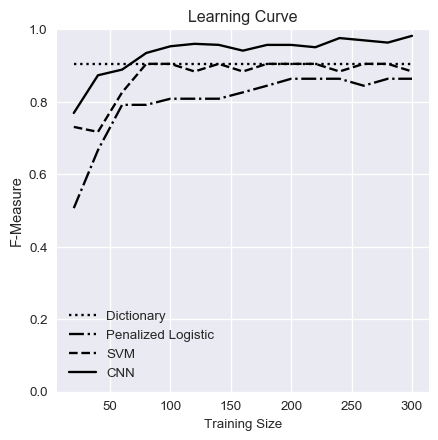

In [241]:
plt.style.use('seaborn')
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

plt.plot(dict_fmeasure.N, dict_fmeasure.fmeasure, color = 'black', linestyle = ':', label = 'Dictionary')
plt.plot(lin_fmeasure.N, lin_fmeasure.fmeasure, color = 'black', linestyle = '-.', label = 'Penalized Logistic')
plt.plot(svm_fmeasure.N, svm_fmeasure.fmeasure, color = 'black', linestyle = '--', label = 'SVM')
plt.plot(cnn_fmeasure.N, cnn_fmeasure.fmeasure, color = 'black', linestyle = '-', label = 'CNN')

plt.ylabel('F-Measure')
plt.title('Learning Curve')
plt.xlabel('Training Size', size = 'medium')

plt.ylim((0,1))

plt.legend()

plt.savefig(data_path + 'learning.png', dpi = 600, bbox_inches="tight")
#plt.show()